In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from pathlib import Path

In [7]:
class Config:
    INPUT_HEIGHT = 224
    INPUT_WIDTH = 224
    IMAGENET_MEAN = [0.50, 0.50, 0.50]
    IMAGENET_STD = [0.50, 0.50, 0.50]
    BATCH_SIZE = 32
    MODEL_NAME = 'vit_base'
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_CLASSES = 4  # Will be set based on dataset

In [8]:
def compute_specificity(confusion_matrix):
    """
    Compute specificity from confusion matrix.
    Specificity = TN / (TN + FP)
    """
    n_classes = confusion_matrix.shape[0]
    specificities = []
    
    for i in range(n_classes):
        # True negatives are the sum of all values except those in row i and column i
        tn = confusion_matrix.sum() - confusion_matrix[i, :].sum() - confusion_matrix[:, i].sum() + confusion_matrix[i, i]
        # False positives are the sum of all values in column i except the true positive
        fp = confusion_matrix[:, i].sum() - confusion_matrix[i, i]
        
        # Avoid division by zero
        if tn + fp == 0:
            specificities.append(0.0)
        else:
            specificities.append(tn / (tn + fp))
            
    return np.mean(specificities)

def evaluate_model(model, test_loader, target_names, model_name="Model", output_dir=None):
    """
    Evaluate a model with detailed metrics including specificity
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    print(f"Evaluating {model_name} on {device}...")
    
    with torch.inference_mode():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Convert to numpy arrays
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    specificity = compute_specificity(cm)
    
    # Print confusion matrix
    print(f"\n{model_name} - Confusion Matrix:")
    print(cm)
    
    # Print classification report with more decimal places
    report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
    print(f"\n{model_name} - Classification Report:")
    print(report)
    
    # Print metrics with 4 decimal places
    print(f"{model_name} - Metrics (Macro-Averaged):")
    print(f"  Accuracy:    {accuracy:.4f}")
    print(f"  Precision:   {precision:.4f}")
    print(f"  Recall:      {recall:.4f}")
    print(f"  Specificity: {specificity:.4f}")
    print(f"  F1 Score:    {f1:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Save figure if output_dir is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, f"{model_name.replace(' ', '_')}_confusion_matrix.png"))
    
    plt.show()
    
    # Return metrics dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'confusion_matrix': cm
    }

def load_model(model_path, num_classes):
    """
    Load a model from a checkpoint file
    """
    from super_gradients.training import models
    
    # Initialize the model architecture
    model = models.get(Config.MODEL_NAME, num_classes=num_classes, pretrained_weights='imagenet')
    
    # Load the checkpoint
    checkpoint = torch.load(model_path, map_location=Config.DEVICE)
    
    # Handle different checkpoint formats
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    
    return model

def create_test_dataloader(test_dir, batch_size=32, num_workers=2):
    """
    Create a test dataloader from a directory
    """
    # Test transforms - no augmentation
    test_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((Config.INPUT_HEIGHT, Config.INPUT_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=Config.IMAGENET_MEAN, std=Config.IMAGENET_STD),
    ])
    
    # Create dataset
    test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
    
    # Create dataloader
    test_loader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return test_loader, test_data.classes

In [9]:
checkpoint_path = 'checkpoints/dec4ckpt_best.pth'  # Replace with actual path
test_dir = 'content/test'              # Replace with actual path
output_dir = 'evaluation_results'
model_name = 'ViT Model'
batch_size = 32
os.makedirs(output_dir, exist_ok=True)

In [10]:
test_loader, class_names = create_test_dataloader(test_dir, batch_size=batch_size)

In [11]:
Config.NUM_CLASSES = len(class_names)
print(f"Found {Config.NUM_CLASSES} classes: {class_names}")

Found 4 classes: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


In [12]:
model = load_model(checkpoint_path, Config.NUM_CLASSES)
print(f"Loaded model from {checkpoint_path}")

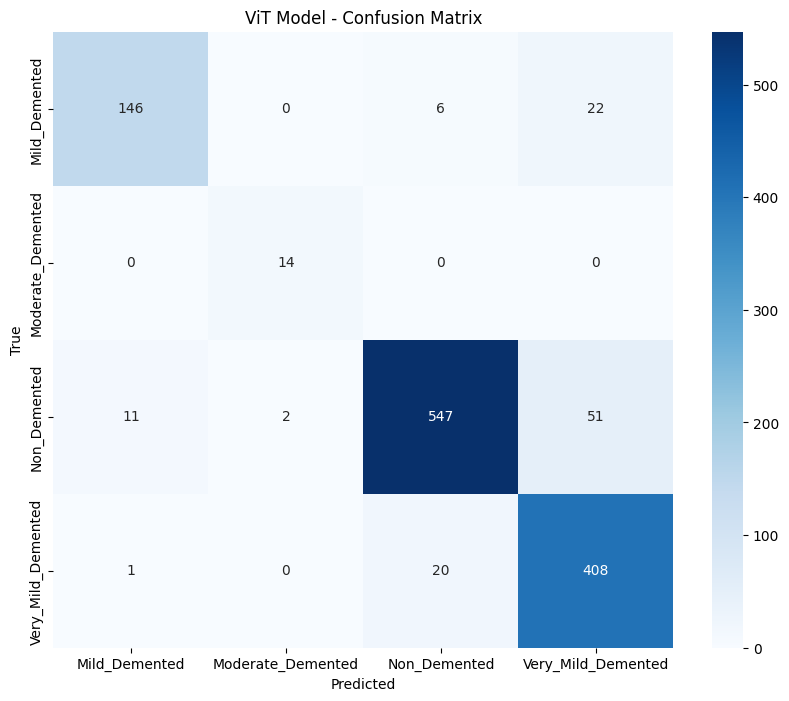

In [13]:
metrics = evaluate_model(
    model=model,
    test_loader=test_loader,
    target_names=class_names,
    model_name=model_name,
    output_dir=output_dir
)

In [14]:
import json
metrics_copy = metrics.copy()
metrics_copy['confusion_matrix'] = metrics_copy['confusion_matrix'].tolist()  # Convert numpy array to list

with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(metrics_copy, f, indent=4)

print(f"Results saved to {output_dir}")